In [154]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.distributions import Normal,Categorical
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image 

In [149]:
class Qtable(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(num_inputs, 32, 8, stride=4, padding=0), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=0), 
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=0), 
            nn.ReLU(),
            nn.Flatten())
        
        
        self.q_net = nn.Sequential(
            nn.Linear(1920, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs)
        )
    
    def forward(self, x):
        x = self.convs(x)
        value = self.q_net(x)
        return value

In [155]:
breakout_inputdim = (1, 82, 72)

# This is a little method that will do preprocessing of breakout input for us
def prepro(image):
    image = image[32:196]  # crop
    copy = np.transpose(image, (1,0))
    image = copy[8:152]
    image = np.transpose(image, (1,0))
    image = image[::2, ::2]
    tens = TF.to_tensor(image)
    tens = tens.unsqueeze(0)
    return tens, np.reshape(image, breakout_inputdim)

(1, 82, 72)


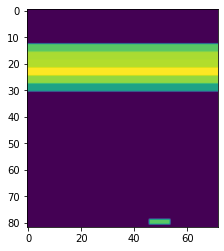

In [151]:
env = gym.make("ALE/Breakout-v5", obs_type="grayscale")
# visualize the original image vs. the newly processed array.

raw_image = env.reset()
_, preprocessed_image = prepro(raw_image[0])
print(preprocessed_image.shape)
plt.imshow(preprocessed_image.squeeze(0))
# im = Image.fromarray(raw_image[0]) 
# im.save("your_file.jpeg")
# print(raw_image[0].shape)
# plt.imshow(raw_image[0])
# plt.show()


In [165]:
env = gym.make("ALE/Breakout-v5", obs_type="grayscale")
model = Qtable(1, 4, 256)
obs = env.reset()[0]
obs, _ = prepro(obs)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

optimizer.zero_grad()  # Zero the gradients
outputs = model(obs)  # Forward pass
target_distribution = outputs[:, 3]  # Extract the target distribution
loss = criterion(target_distribution, torch.tensor([10], dtype=torch.float32))  # Calculate the loss only for the target node
loss.backward()  # Backward pass
optimizer.step()  # Update weights